# Projet Fil Rouge 2023 : Reconnaissance de commandes audio


**Noms :** de Brandois, Phung

**Prénoms :** Félix, Anh Minh

**Nom du binôme :** 2 fauves 2 frères


Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="files/DroneJS.JPG" width="600" height="500"  >



Ces séances se décomposent en ces parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re

# Preprocessing

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 

In [2]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')

The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [3]:
def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [4]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


### Spectral representation

1. Apply a Fourier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.

In [5]:
from scipy import signal
from scipy.fft import fft
from sklearn.decomposition import PCA

In [6]:
X_hat = fft(X, axis=1)
print(f'Shape of the Fourier Transform of X is {X_hat.shape}')

Shape of the Fourier Transform of X is (54, 18522)


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Since the number of variables (columns) are way higher than the number of samples (rows), the estimations of the parameters will not be accurate : $p >> n$.
</div>

2. Let $\hat{X}$ be the Fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

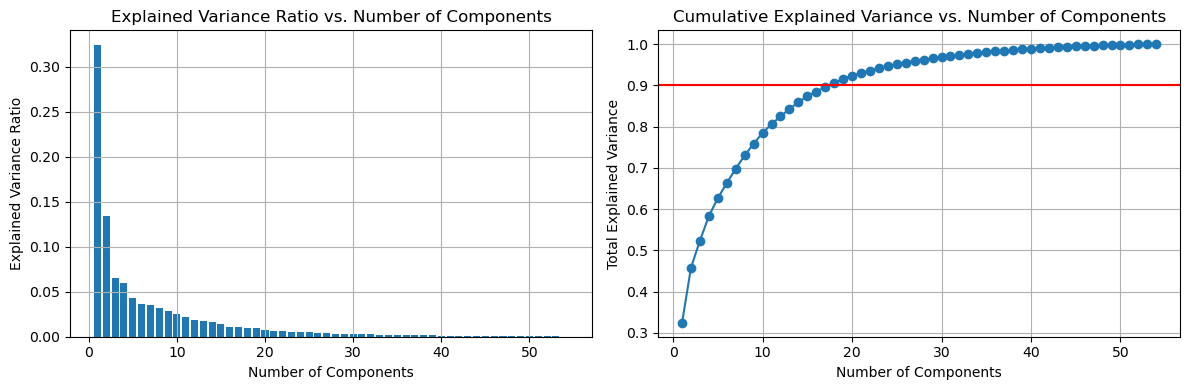

In [7]:
# Apply PCA
pca = PCA()
pca.fit(np.abs(X_hat))

plt.figure(figsize=(12, 4))

# Plot the explained variance ratio for individual components
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, align='center')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)

# Plot the cumulative explained variance ratio
plt.subplot(1, 2, 2)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Total Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.axhline(y=0.90, color="r")
plt.grid(True)

plt.tight_layout()
plt.show()

We choose the number of component such as 90% of the variance is explained : 18.

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$ ?  

Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female

(127, 147)


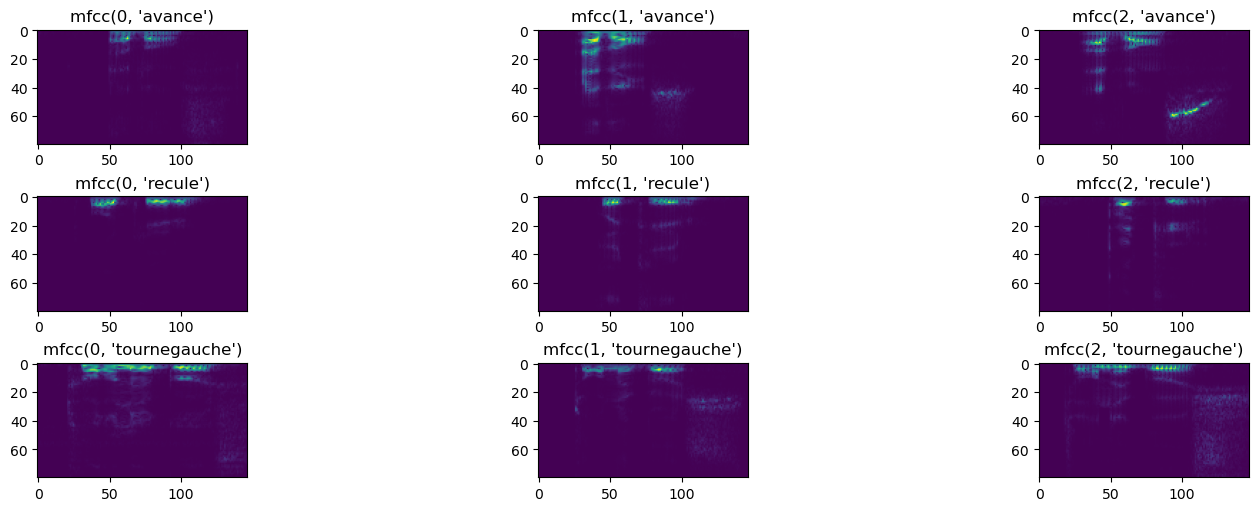

In [8]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxx.shape)
plt.show()

#### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT. 
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time. Add a second argument that gives the maximum frequency index

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

In [120]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation        
        return np.absolute(fft(X)[:, :self.idx_frequence_max])

In [121]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, stat='mean', idx_frequence_max=None):
        self.stat = stat
        self.idx_frequence_max = idx_frequence_max
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Compute the STFT
        _, _, Zxx = signal.stft(X)
        X_stft = np.abs(Zxx)

        # Limit to the specified maximum frequency index
        if self.idx_frequence_max is not None:
            X_stft = X_stft[:, :self.idx_frequence_max, :]

        # Compute the specified statistic along the time axis
        if self.stat == 'mean':
            X_transformed = np.mean(X_stft, axis=1)
        elif self.stat == 'quantile':
            X_transformed = np.quantile(X_stft, 0.5, axis=1)  # Median
        elif self.stat == 'max':
            X_transformed = np.max(X_stft, axis=1)
        elif self.stat == 'min':
            X_transformed = np.min(X_stft, axis=1)
        else:
            raise ValueError("Unsupported stat type. Choose from 'mean', 'quantile', 'max', 'min'.")

        return X_transformed

# Partie I : Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_compenents")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut

#### Without scaling

In [140]:
# Linear regression on the first PCA components of FFT
fourier_transform = FFT()
pca = PCA()
regression = LogisticRegression(max_iter=10000)

# Define the pipeline
params = {
    "pca__n_components": [5, 10, 20, 50],
    "regression__C": [0.001, 0.01, 0.1],
    "regression__solver": ["lbfgs"],
    "regression__multi_class": ["ovr"]}

pipeline = Pipeline(steps = [('fft', fourier_transform),
                             ('pca', pca),
                             ('regression',regression)])

clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X, y)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')
model_fft_no_scale = clf.best_estimator_

{'pca__n_components': 10, 'regression__C': 0.001, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs'}
The accuracy of the model is 0.7777777777777778


In [128]:
# Linear regression on the first PCA components of STFT
stft = STFT()
regression = LogisticRegression(max_iter=10000)

# Define the pipeline
params = {
    "regression__C": [10, 100, 1000],
    "regression__solver": ["lbfgs"],
    "regression__multi_class": ["ovr"],
    "stft__stat": ['max'],
    "stft__idx_frequence_max":[10, 20, 40, 60]}

pipeline = Pipeline(steps = [('stft', stft),
                             ('regression',regression)])

clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X, y)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')
model_stft_no_scale = clf.best_estimator_

{'regression__C': 100, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs', 'stft__idx_frequence_max': 20, 'stft__stat': 'max'}
The accuracy of the model is 0.7222222222222222


#### With scaling

In [138]:
# Linear regression on the first PCA components of FFT with scaling
fourier_transform = FFT()
pca = PCA()
regression = LogisticRegression(max_iter=10000)
scaler = StandardScaler()

# Define the pipeline
params = {
    "pca__n_components": [10, 20, 50],
    "regression__C": [0.001, 0.01, 0.1],
    "regression__solver": ["lbfgs"],
    "regression__multi_class": ["ovr"]}

pipeline = Pipeline(steps = [("scaler", scaler),
                             ('fft', fourier_transform),
                             ('pca', pca),
                             ('regression',regression)])

clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X, y)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')
model_fft_with_scale = clf.best_estimator_

{'pca__n_components': 20, 'regression__C': 0.01, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs'}
The accuracy of the model is 0.8518518518518519


In [96]:
# Linear regression on the first PCA components of STFT with scaling
stft = STFT()
regression = LogisticRegression(max_iter=10000)
scaler = StandardScaler()

# Define the pipeline
params = {
    "regression__C": [0.01, 0.1, 1],
    "regression__solver": ["lbfgs"],
    "regression__multi_class": ["ovr"],
    "stft__stat": ['max'],
    "stft__idx_frequence_max":[10, 20, 40, 60],
    }

pipeline = Pipeline(steps = [("scaler", scaler),
                             ('stft', stft),
                             ('regression',regression)])

clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X, y)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')
model_stft_with_scale = clf.best_estimator_

{'regression__C': 0.1, 'regression__multi_class': 'ovr', 'regression__solver': 'lbfgs', 'stft__idx_frequence_max': 40, 'stft__stat': 'max'}
The accuracy of the model is 0.7777777777777778


### Evaluation of results

Evaluate the result by confusion matrix and percentage of correct classification.

*Tip:* Remember to put a function to display the confusion matrix

In [97]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

accuracy :  0.6363636363636364


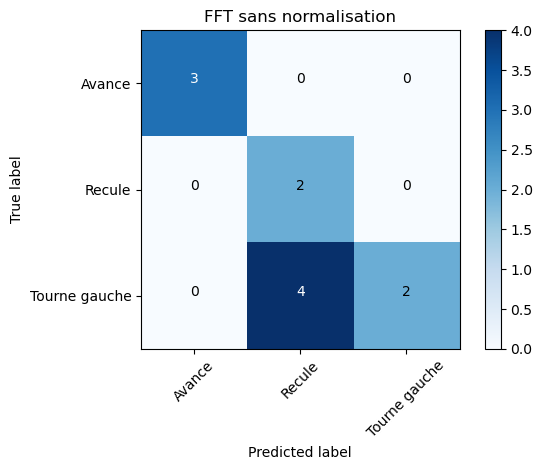

accuracy :  0.5454545454545454


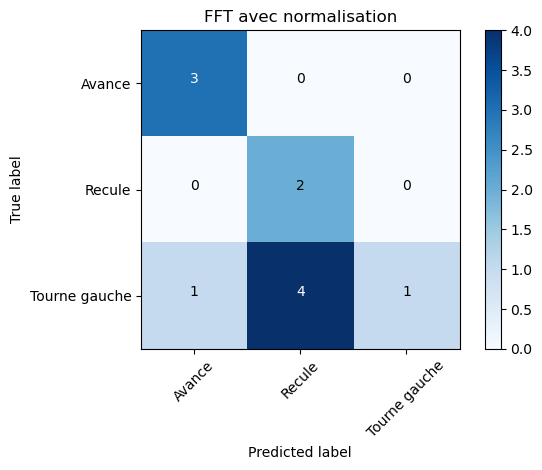

accuracy :  0.45454545454545453


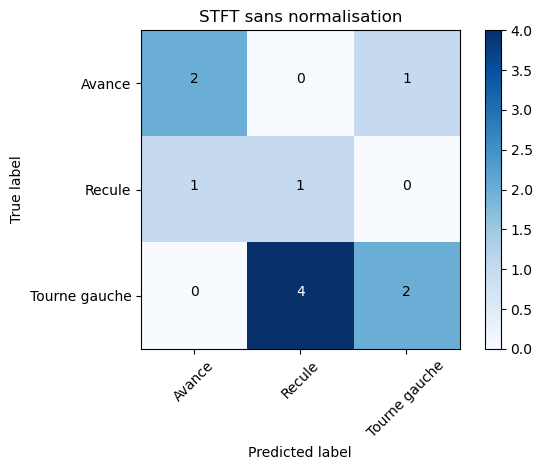

accuracy :  0.5454545454545454


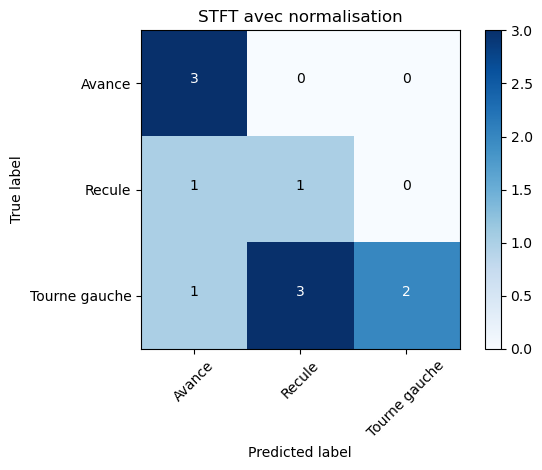

In [142]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# All models
all_models = [model_fft_no_scale,
              model_fft_with_scale,
              model_stft_no_scale,
              model_stft_with_scale]
model_names = ["FFT sans normalisation",
               "FFT avec normalisation",
               "STFT sans normalisation",
               "STFT avec normalisation"]
classes = ["Avance", "Recule", "Tourne gauche"]

# Compute the confusion matrix for each model
for i, m in enumerate(all_models):
    
    # Fit the model
    m.fit(X_train, y_train)
    
    # Predict the test set
    pred = m.predict(X_test)
    score = accuracy_score(y_test, pred) 
    confusion = confusion_matrix(y_test, pred)
    print("accuracy : ", score)
    
    # Plot the confusion matrix
    plt.imshow(confusion, cmap=plt.cm.Blues)
    plt.title(model_names[i])
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Format and display the labels
    thresh = confusion.max() / 2.0
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            plt.text(j, i, format(confusion[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if confusion[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()


# Part II: Classification by kernel methods

**Reminder** Kernel methods consist of plunging the data into a space of Hilbert dimension $\mathcal{H}$ where the data can be separated linearly.

**Representation Theorem:** The solution of the infinite dimensional separation problem is contained in a finite dimensional vector subspace of $\mathcal{H}$

### 1. Perform a core SVM classification

    1) Vary the core
    2) Vary the regularization parameter.

In [114]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC

In [143]:
# Classification using SVM
svm = SVC()

# Define the pipeline
params = {
    "stft__stat": ['max'],
    "stft__idx_frequence_max": [5, 10, 20],
    "svm__C": [1, 10, 100],
    "svm__kernel": ["rbf", "linear", "poly"],
    "svm__gamma": [0.1],
    }

pipeline = Pipeline(steps = [("scaler", StandardScaler()),
                             ("stft", STFT()),
                             ('svm', svm)])

clf = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

model = clf.fit(X_train, y_train)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')
model_svm = clf.best_estimator_

{'stft__idx_frequence_max': 5, 'stft__stat': 'max', 'svm__C': 10, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
The accuracy of the model is 0.813953488372093


accuracy :  0.5454545454545454


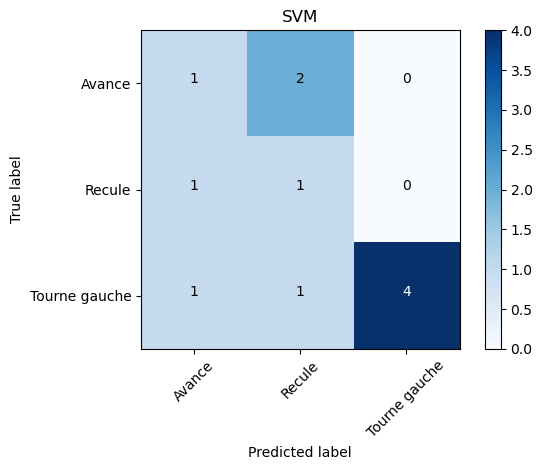

In [144]:
# Compute the confusion matrix for the SVM model
model_svm.fit(X_train, y_train)

# Predict the test set
pred = model_svm.predict(X_test)
score = accuracy_score(y_test, pred)
confusion = confusion_matrix(y_test, pred)
print("accuracy : ", score)

# Plot the confusion matrix
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title("SVM")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Format and display the labels
thresh = confusion.max() / 2.0
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        plt.text(j, i, format(confusion[i, j], 'd'),
                horizontalalignment="center",
                color="white" if confusion[i, j] > thresh else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()

### Draw the classification border in the 2 first components of PCA

In [145]:
def draw_svc_boundaries(X, y, clf):
    h = 1.0
    
    # Plot the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict the decision boundary
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors="black")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("Decision Boundary")

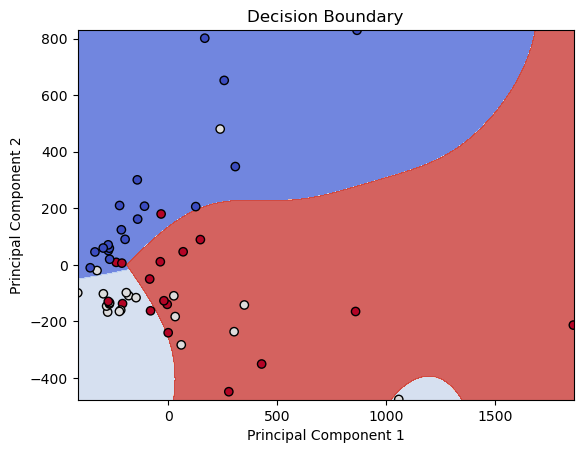

In [148]:
# Create the model
X_fft = FFT().transform(X)
X_pca = PCA(n_components=2).fit_transform(X_fft)
model_svm_pca = GridSearchCV(SVC(kernel="rbf", gamma=4e-6), param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_pca, y).best_estimator_

draw_svc_boundaries(X_pca, y, model_svm_pca)

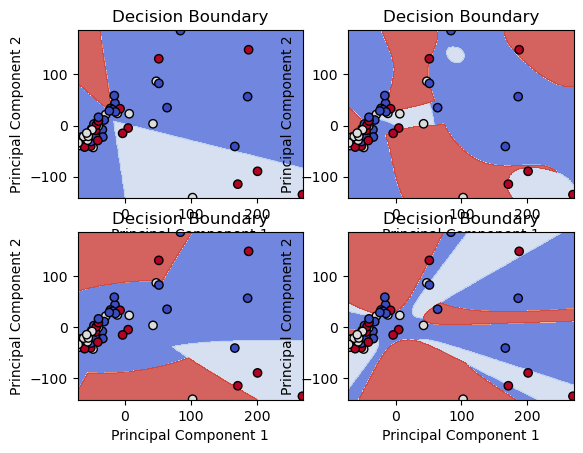

In [147]:
# Plot the decision boundaries for different kernels
fig, axs = plt.subplots(2, 2)
kernels = [
    ("linear", 0),
    ("rbf", 0),
    ("poly", 2),
    ("poly", 4),
]

# Create the pipeline
pipeline = Pipeline(steps = [("fft", FFT()),
                             ("scaler", StandardScaler()),
                             ("pca", PCA(n_components=2))])

X_features = pipeline.fit_transform(X)

for i, k in enumerate(kernels):
    svm = NuSVC(nu=0.1, kernel=k[0], degree=k[1])
    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_features, y).best_estimator_
    plt.subplot(2, 2, i+1)
    draw_svc_boundaries(X_features, y, clf=model)
    
plt.show()


# Part III: Ensemble Method

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

1. First you will transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification

In [151]:
# Create y1
y1 = np.where(y == 1, 1, 0)

2. Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)

In [152]:
# Split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)

# Bagging with Decision Trees
N = X_train.shape[0]
M=100
trees = []
trees_predict = []

# Train
for m in range(M):
    idx = np.random.choice(np.array([i for i in range(N)]), N)
    XB = X_train[idx]
    yB = y_train[idx]
    tree =  DecisionTreeClassifier(max_depth=2)
    tree = tree.fit(XB,yB)
    trees.append(tree)

# Predict
for tree in trees :
    tree_predict = tree.predict(X_test) 
    trees_predict.append(tree_predict)

In [156]:
# Compter le nombre de True dans chaque tableau
counts = np.sum(trees_predict, axis=0)
fcom = counts > (M/2)
accuracy_fcom = accuracy_score(y_test, fcom)
print(f'Accuracy of the model is {accuracy_fcom}')

# Comparision with the mean
accuracy_mean = (trees_predict == y_test).mean()
print(f'Accuracy of the model is {accuracy_mean}')

Accuracy of the model is 0.6818181818181818
Accuracy of the model is 0.5636363636363636


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

We note that the accuracy of bagging is superior to that of the average model, due to its ability to reduce variance and generalize better. By using bootstrap samples and aggregating predictions from multiple base models, bagging captures a greater diversity of perspectives, improving the robustness of predictions and the ability to adapt to varied training data.
</div>

3. Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?

In [157]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [161]:
# Create the model
X_scaled = StandardScaler().fit_transform(X)
X_stft = STFT(stat='max', idx_frequence_max=55).transform(X_scaled)
params = {
    "criterion": ["gini"],
    "max_depth": [2],
    "min_samples_split": [3],
    "n_estimators": [50]
    }

clf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=LeaveOneOut(), n_jobs=-1)
clf.fit(X_stft, y)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')

{'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 3, 'n_estimators': 50}
The accuracy of the model is 0.7037037037037037


<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Yes, Random Forest is a model that uses the bagging technique. Random Forest creates a set of several decision trees using bootstrap samples from the training dataset. Each decision tree is trained on a different bootstrap sample, and the predictions from each tree are aggregated to produce a final prediction.

By combining the predictions of multiple trees trained on bootstrap samples and introducing randomness into tree construction, Random Forest reduces variance and overfitting compared to a single decision tree. This generally results in good predictive performance and a better ability to generalize to new data.

Random Forest is therefore an example of a bagging model using a set of decision trees.
</div>

## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	= t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


In [162]:
# Create y1
y1 = np.where(y == 1, 1, 0)
y1[y1==0]=-1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=0.4, random_state=42)
np.random.seed(seed=42)

# AdaBoost with Decision Trees
N = X_train.shape[0]
weights = []

for i in range(N) :
    weights.append(1/N)
    
M=100
trees=[]
alphas = []

# Train
for m in range(M):
    tree =  DecisionTreeClassifier(max_depth=1)
    tree = tree.fit(X_train,y_train,sample_weight = weights)
    trees.append(tree)
    tree_predict = tree.predict(X_train) 
    em = np.dot((tree_predict!=y_train),weights) / np.sum(weights)
    alpha = np.log((1-em)/em)
    alphas.append(alpha)
    weigths = np.multiply(weights,np.exp(alpha*(tree_predict!=y_train)))

# Predict
trees_prediction = np.zeros((M,y_test.shape[0]))
for m in range(M):
    tree_prediction= trees[m].predict(X_test)
    trees_prediction[m] = tree_prediction 

In [163]:
# Compute the weighted sum of the predictions
Ym = np.matmul(alphas,trees_prediction)
Ym = np.sign(Ym)

accuracy = accuracy_score(y_test, Ym)
print(f'Accuracy of the model is {accuracy}')

Accuracy of the model is 0.6818181818181818


**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


In [164]:
from sklearn.ensemble import AdaBoostClassifier

In [167]:
# Create the model
X_scaled = StandardScaler().fit_transform(X)
X_stft = STFT(stat='max', idx_frequence_max=55).transform(X_scaled)
params = {
    "algorithm" : ["SAMME","SAMME.R"],
    "n_estimators": range(50,301,50)
    }

clf = GridSearchCV(AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth=2)), param_grid=params, cv=LeaveOneOut(), n_jobs=-1)
clf.fit(X_stft, y)

# Print the best parameters
print(clf.best_params_)
print(f'The accuracy of the model is {clf.best_score_}')

{'algorithm': 'SAMME.R', 'n_estimators': 200}
The accuracy of the model is 0.7037037037037037


# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [170]:
import torch
import torch.nn as nn

In [169]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5, random_state=42)

# Apply transformations
X_train = StandardScaler().fit_transform(X_train)
X_train = STFT(stat='max', idx_frequence_max=55).transform(X_train)

X_test = StandardScaler().fit_transform(X_test)
X_test = STFT(stat='max', idx_frequence_max=55).transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    
    

In [181]:
X_train.shape

torch.Size([27, 1, 146])

In [182]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(146, 3)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.softmax(self.network(xb), dim=1)

In [190]:
model = NNClassification()
num_epochs = 100

result_test_loss = []
result_train_loss = []
result_test_acc = []
result_train_acc = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    train_acc = 0
    
    for i in range(X_train.shape[0]):
        # Compute the prediction
        pred = model(X_train[i])
        
        # Compute the loss
        loss_value = loss(pred, y_train[i])
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        train_losses.append(loss_value.item())
        train_acc += torch.eq(y_train[i].argmax(), pred.argmax()).int()
        
    result_train_acc.append(train_acc / X_train.shape[0])
        
    model.eval()
    test_losses = []
    test_acc = 0
    
    for i in range(X_test.shape[0]):
        # Compute the prediction
        pred = model(X_test[i])
        
        # Compute the loss
        loss_value = loss(pred, y_test[i])
        test_losses.append(loss_value.item())
        test_acc += torch.eq(y_test[i].argmax(), pred.argmax()).int()
        
    result_test_acc.append(test_acc / X_test.shape[0])

    result_train_loss.append(torch.mean(torch.tensor(train_losses)).item())
    result_test_loss.append(torch.mean(torch.tensor(test_losses)).item())

**Question 2:** Plot the train and test loss. What do you observe?

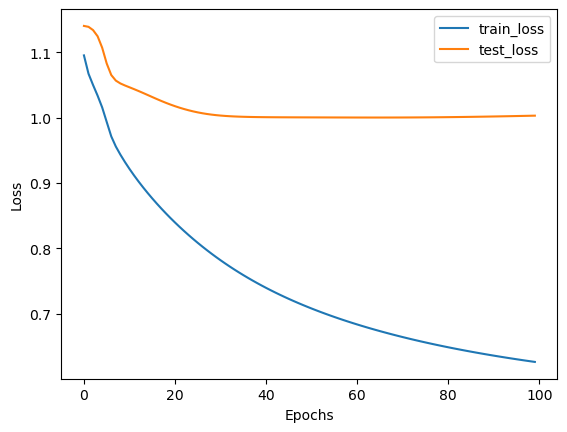

In [191]:
plt.plot(result_train_loss, label = "train_loss")
plt.plot(result_test_loss, label = "test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

We observe a decrease of the loss. But the test_loss > train_loss so it means that we have an overfitting.

</div>

**Question 3 :** Compute the accuracy.

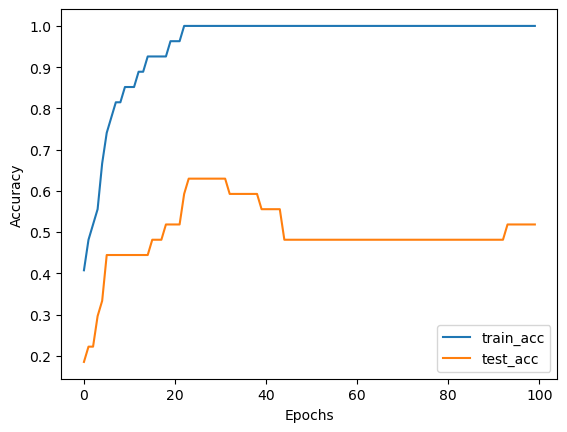

In [193]:
plt.plot(result_train_acc, label = "train_acc")
plt.plot(result_test_acc, label = "test_acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

**Question 4:** If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

In [196]:
class NNClassification(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.network = torch.nn.Sequential(
            nn.Linear(146, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 3)
        )
    
    def forward(self, xb):
        return torch.softmax(self.network(xb), dim=1)

In [197]:
model = NNClassification()
num_epochs = 100

result_test_loss = []
result_train_loss = []
result_test_acc = []
result_train_acc = []

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss = nn.CrossEntropyLoss()

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    train_acc = 0
    
    for i in range(X_train.shape[0]):
        # Compute the prediction
        pred = model(X_train[i])
        
        # Compute the loss
        loss_value = loss(pred, y_train[i])
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        train_losses.append(loss_value.item())
        train_acc += torch.eq(y_train[i].argmax(), pred.argmax()).int()
        
    result_train_acc.append(train_acc / X_train.shape[0])
        
    model.eval()
    test_losses = []
    test_acc = 0
    
    for i in range(X_test.shape[0]):
        # Compute the prediction
        pred = model(X_test[i])
        
        # Compute the loss
        loss_value = loss(pred, y_test[i])
        test_losses.append(loss_value.item())
        test_acc += torch.eq(y_test[i].argmax(), pred.argmax()).int()
        
    result_test_acc.append(test_acc / X_test.shape[0])

    result_train_loss.append(torch.mean(torch.tensor(train_losses)).item())
    result_test_loss.append(torch.mean(torch.tensor(test_losses)).item())

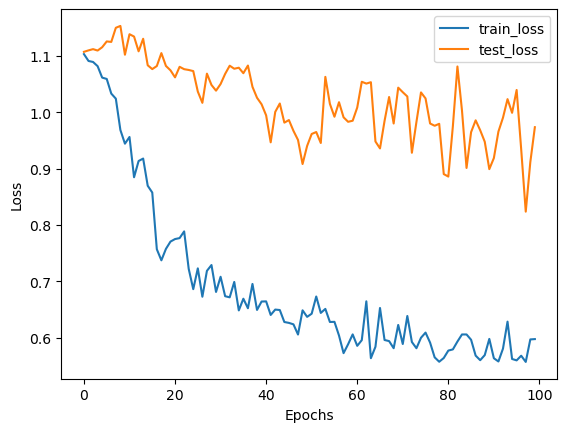

In [198]:
plt.plot(result_train_loss, label = "train_loss")
plt.plot(result_test_loss, label = "test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

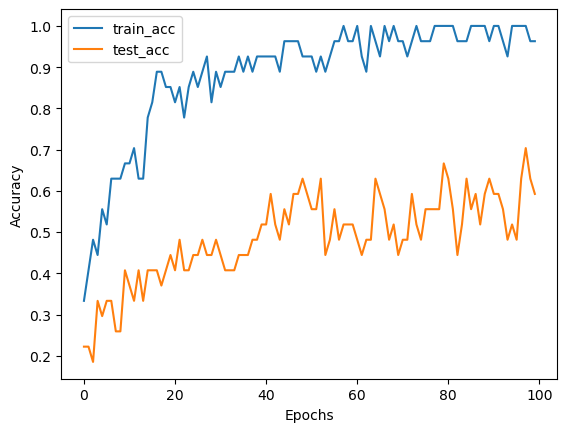

In [199]:
plt.plot(result_train_acc, label = "train_acc")
plt.plot(result_test_acc, label = "test_acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

<div style="background-color:rgba(255, 0,0, 0.1); padding:15px;">

Even after regularization, we don't have better results. We might have to change our architecture.

</div>

**Question 5(Bonus)** : Create a CNN that takes in input the accoustic signal without preprocessing